In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# basic functions

def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

def catTriangle(w,l):
    return int(math.factorial(w+l)*(w+-l+1)/(math.factorial(l)*math.factorial(w+1)))

def catTrapezoid(w,l,m):
    if 0 <= l < m:
        return nCr(w + l, l)
    elif m <= l <= w + m -1:
        return nCr(w+l,l) - nCr(w+l,l-m)
    else:
        return 0

dp = {}
def catTrapezoidWeighted(w,l,m,a,b):
    f = (w,l,m,a,b)
    if f in dp:
        return dp[f]
    if l == 0:
        return 1
    elif b*l >= a*w + m:
        return 0
    elif w == 0:
        return 1
    else:
        val = catTrapezoidWeighted(w-1,l,m,a,b) + catTrapezoidWeighted(w,l-1,m,a,b)
        dp[f] = val
        return dp[f]
    
dp2 = {}
def catTrapezoidWeightedInverse(x,w,l,p,q,c):
    f = (x,w,l,p,q,c)
    if f in dp2:
        return dp2[f]
    else:
        x_new = x_update(x,w,l,p,q)
        if local_reward(x_new,p,q,c) < 0:
            dp2[f] = 0
            return dp2[f]
        elif w == 0 and l == 0:
            dp2[f] = 1
            return dp2[f]
        elif l == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c)
            return dp2[f]
        elif w == 0:
            dp2[f] = catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]
        else:
            dp2[f] = catTrapezoidWeightedInverse(x,w-1,l,p,q,c) + catTrapezoidWeightedInverse(x,w,l-1,p,q,c)
            return dp2[f]

def getAB(p,q,x):
    a = math.log(p/q)
    b = math.log((1-q)/(1-p))

    return (a/b).as_integer_ratio()
        
def update_prior(x,p,q,result):
    if result == True:
        return p*x/(win(x,p,q))
    else:
        return (1 - p)*x/(lose(x,p,q))

def prior_inverse(x,p,q,result):
    if result == True:
        return x*q/(p - x*p + x*q)
    else:
        return x*(1-q)/( (1-p) - x*(1-p) + x*(1-q))

def local_reward(x,p,q,c):
    out = win(x,p,q) - c
    return out

def win(x,p,q):
    return x*p + (1-x)*q

def lose(x,p,q):
    return x*(1-p) + (1-x)*(1-q)

def x_update(x,w,l,p,q):
    return  (x*p**w*(1-p)**l)/(x*p**w*(1-p)**l + (1-x)*q**w*(1-q)**l)

def expected_profit(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while local_reward(x_new,p,q,c) >= 0 and possibleLosses < 40:
        possibleLosses += 1
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2))
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
#             elif paths == 0 and catTrapezoid(w,l-1,possibleLosses+1) > 0:
#                 tot += delta**t*(c - c2)*catTrapezoid(w,l-1,possibleLosses+1)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
                
    return tot

def expected_profit_weighted(x,p,q,c,c2,delta,rounds=100):
    
    if c < c2 or local_reward(x,p,q,c) < 0:
        return 0
    
    tot = 0

    for t in range(rounds):
        lowest = 0
            
        for w in range(lowest,t + 1,1):
            l = t - w
#             print(f"t: {t}, w: {w}, l: {l}, paths: {catTrapezoidWeightedInverse(x,w,l,p,q,c)}")
            paths = catTrapezoidWeightedInverse(x,w,l,p,q,c)
            if paths > 0 or l == 0:
                tot += delta**t*(c - c2)*paths*prob_reach(x,w,l,p,q)
#             elif paths == 0 and catTrapezoidWeightedInverse(x,w,l-1,p,q,c) > 0: # final loss
#                 tot += delta**t*(c - c2)*catTrapezoidWeightedInverse(x,w,l-1,p,q,c)*prob_reach(x,w,l-1,p,q)*lose(x_update(x,w,l-1,p,q),p,q)
    return tot

# dynamic pricing

def dynamic_profit(x,x2,p,q,c2,delta,rounds=100):
    
#     if c < c2 or local_reward(x,p,q,c) < 0:
#         return 0
    tot = 0
    
    # first, get possible losses
    possibleLosses = 0
    x_new = x
    while x >= x2 and possibleLosses < 40:
        possibleLosses += 1
        x_new = update_prior(x_new,p,q,False)
    possibleLosses -= 1
    
    for t in range(rounds):
        lowest = max(0,int((t-possibleLosses+1)/2))
            
        for w in range(lowest,t + 1,1):
            l = t - w
            paths = catTrapezoid(w,l,possibleLosses+1)
            if paths > 0 or l == 0:
                tot += delta**t*(win(x,p,q) - c2)*paths*prob_reach(x,w,l,p,q)
                
    return tot

def prob_reach(x,w,l,p,q):
    prob = 1
    for i in range(w):
        prob *= win(x,p,q)
        x = update_prior(x,p,q,True)
    for i in range(l):
        prob *= lose(x,p,q)
        x = update_prior(x,p,q,False)
    return prob

def getPossibleCX(x,p,q,c):
    # todo: add c2
    # returns the possible static prices such that local reward > 0
    if local_reward(x,p,q,c) < 0:
        return []
    elif x == 1:
        return []
    else:
        kList = []
        possible = True
        k = 0
        while possible: # todo if c < q then forever
            if local_reward(x,p,q,c) <= 0 or k > 30:
                possible = False
            k += 1
            c2 = win(x,p,q)
            kList.append(c2)
#             print(c2, k)
            x = update_prior(x,p,q,False)
        return kList

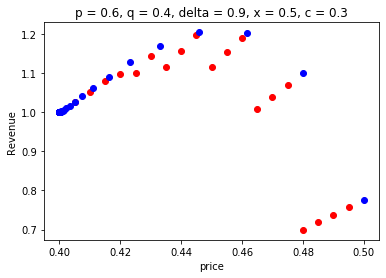

In [2]:
x = 0.5
p = 0.6
q = 0.4
# c = 0.40001
c2 = 0.3
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.4 + 0.005*i for i in range(20)]
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')

prices = getPossibleCX(x,p,q,c2)
profits = []
for i in range(len(prices)):
    ep = expected_profit(x,p,q,prices[i],c2,delta,100)
#     print(prices[i],ep)
    profits.append(ep)

y = dynamic_profit(x,0.34,p,q,c2,delta)    
    
plt.plot(prices,profits,'bo')
plt.xlabel('price')
plt.ylabel('Revenue')
# plt.axhline(y=y,label='test')
# plt.text(10.1,0,'blah',rotation=90)
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()


0.4 0.9999734386522944
0.405 0.9566355472528827
0.41000000000000003 0.9686341287274522
0.41500000000000004 0.9906562630640537
0.42000000000000004 1.0044463548010085
0.42500000000000004 1.030371996398837
0.43000000000000005 1.0365452621973559
0.43500000000000005 1.0410948812525203
0.44 1.071629809088964
0.445 1.0960703350405827
0.45 1.1101212793406836
0.455 1.1033919778866148
0.46 1.1384623947699524
0.465 1.0910171150528638
0.47000000000000003 1.1136616708339384
0.47500000000000003 1.1462404434630162
0.48000000000000004 1.1590071768592878
0.48500000000000004 1.1521556913322761
0.49 1.1829165924231164
0.495 1.1247200288167014
0.5 1.153475292058635
0.505 0.9288676355529448
0.51 0.9514218523346398
0.515 0.9624807482250827
0.52 0.9848384972179712
0.525 0.9835060940147544
0.53 1.0053248944552904
0.535 0.9728725015355267
0.54 0.9935207058385731
0.545 0.8587232792209414


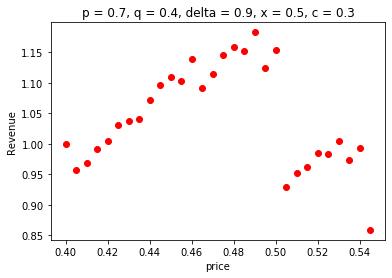

In [3]:
x = 0.5
p = 0.7
q = 0.4
# c = 0.40001
c2 = 0.3
delta = 0.9

# plot
# prices = getPossibleCX(x,p,q,c2)
prices = [0.4 + 0.005*i for i in range(30)]
profits = []
for i in range(len(prices)):
    ep = expected_profit_weighted(x,p,q,prices[i],c2,delta)
    print(prices[i],ep)
    profits.append(ep)
    
plt.plot(prices,profits, 'ro')
plt.xlabel('price')
plt.ylabel('Revenue')
plt.title(f'p = {p}, q = {q}, delta = {delta}, x = {x}, c = {c2}')
plt.show()